# Project Text Mining - Group 8

Nama & NIM : 

            - Marvin Sachio - 2602064475
            - Fernaldy Ferdinand - 2602068605 

Data Used: https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health 

# 1. Importing Library 
importing necessary library for data loading, text representation, text processing, modeling, and evaluation.

In [36]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from collections import Counter

import re
import unicodedata
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import words 
nltk.download('words')
nltk.download('omw-1.4') 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

import spacy

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

# 2. Loading Data 

In [3]:
data_path = '/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv'
df = pd.read_csv(data_path)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.dropna(inplace = True)

load CSV from kaggle database, and dropping missing value and dropping unused column

In [4]:
df.shape

(52681, 2)

checking the shape of the dataset

In [5]:
df['statement_len'] = df['statement'].apply(lambda x: len(x.split(' ')))
df.head() 

,statement,status,statement_len
0,oh my gosh,Anxiety,3
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14
3,I've shifted my focus to something else but I'...,Anxiety,11
4,"I'm restless and restless, it's been a month n...",Anxiety,14


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52681 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   statement      52681 non-null  object
 1   status         52681 non-null  object
 2   statement_len  52681 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


In [7]:
df.describe(include='object').T

,count,unique,top,freq
statement,52681,51073,what do you mean?,22
status,52681,7,Normal,16343


# 3. EDA and Preprocessing

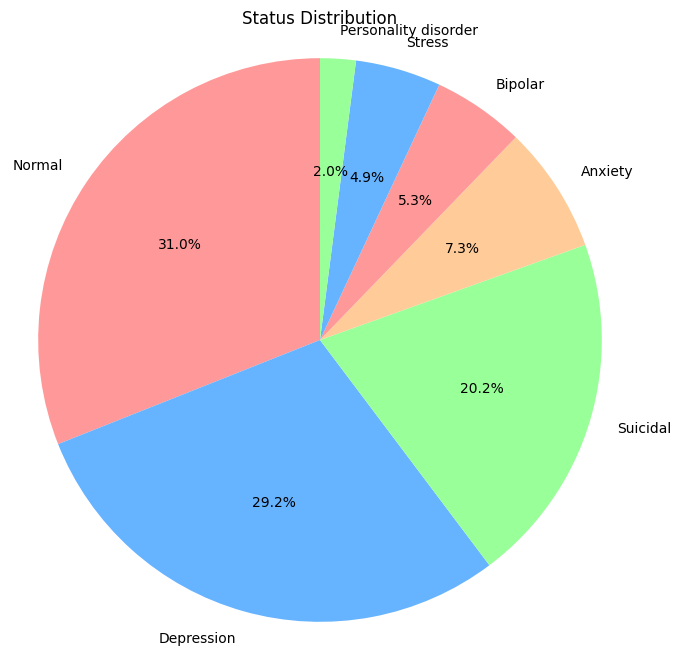

In [8]:
status_counts = df['status'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Status Distribution')
plt.axis('equal')  
plt.show()

from this pie chart alone we could say that the data is imbalance, technique such as oversampling or undersampling could be used

In [9]:
df['num_words'] = df['statement'].apply(lambda x: len(x.split()))
df['avg_word_length'] = np.round(df['statement_len'] / df['num_words'])
df['avg_word_length'] = df['avg_word_length'].map(int)
df['vocabulary_size'] = df['statement'].apply(lambda x: len(set(x.split())))
df.head()

,statement,status,statement_len,num_words,avg_word_length,vocabulary_size
0,oh my gosh,Anxiety,3,3,1,3
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,10,1,10
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,14,1,13
3,I've shifted my focus to something else but I'...,Anxiety,11,11,1,11
4,"I'm restless and restless, it's been a month n...",Anxiety,14,14,1,14


creating feature for analysis purposes


num_words: Indicates verbosity; longer statements may indicate detailed thought processes.


avg_word_length: Reflects the complexity of language used. Shorter words may indicate casual tone, while longer words could suggest a formal or technical tone.


vocabulary_size: Measures the richness of language, which can provide insights into mental health (e.g., repetitive words might reflect limited expression).

In [10]:
num_feature = [feature for feature in df.columns if df[feature].dtype != 'O']

num_feature

['statement_len', 'num_words', 'avg_word_length', 'vocabulary_size']

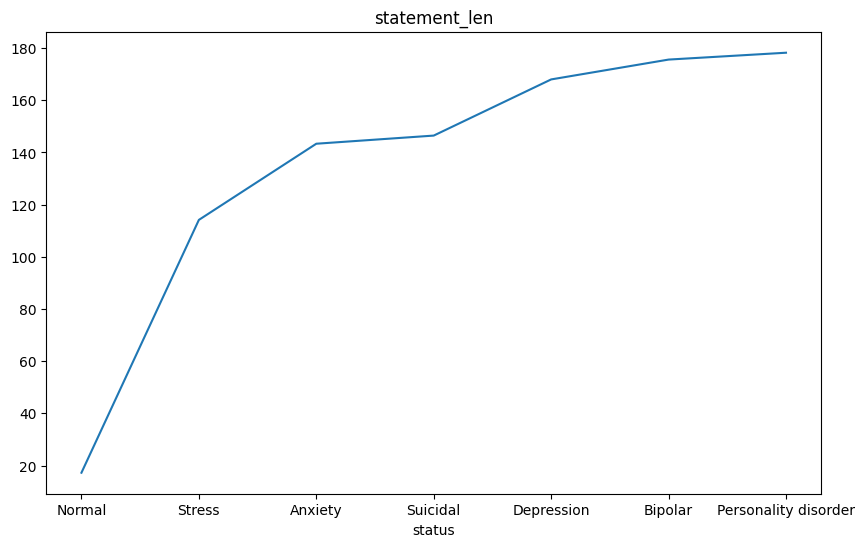

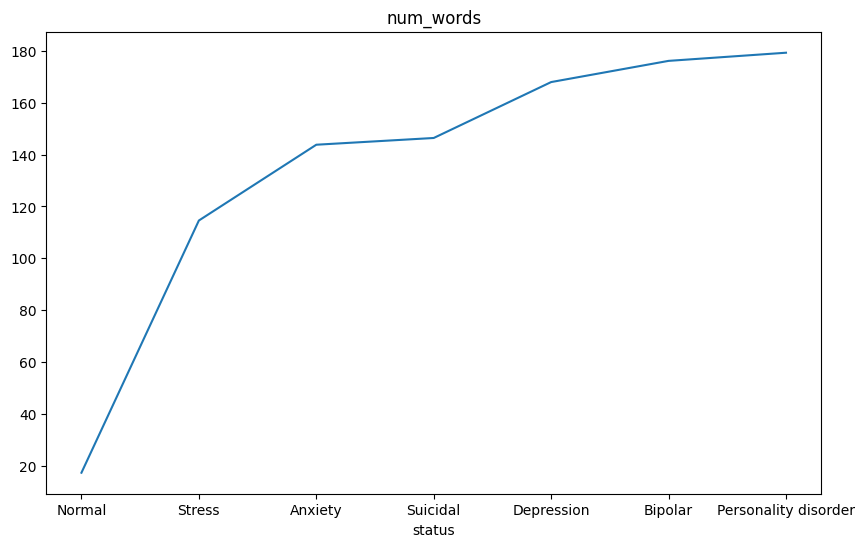

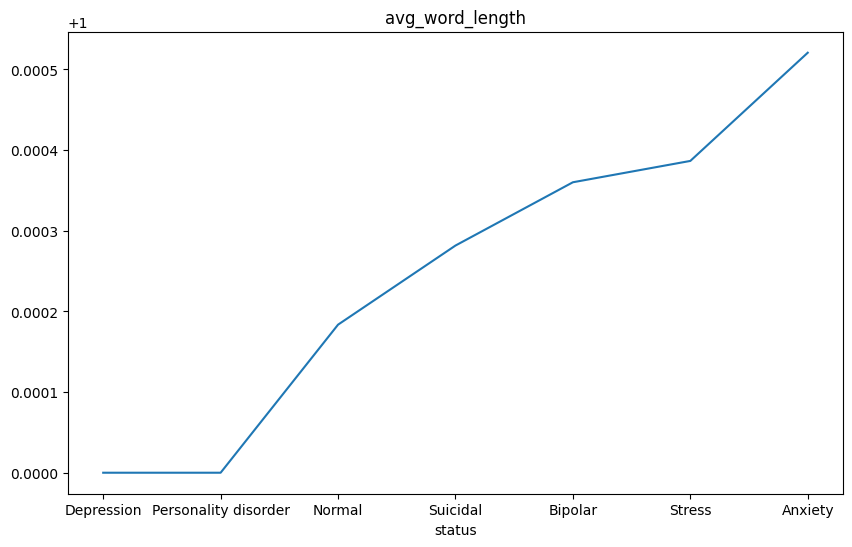

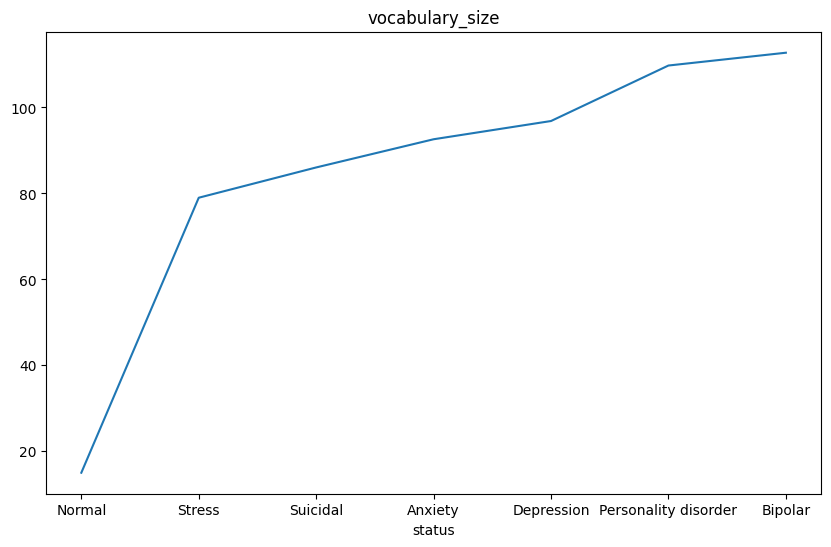

In [11]:
for feature in num_feature:
    plt.figure(figsize= (10,6))
    df.groupby('status')[feature].mean().sort_values().plot()
    plt.title(feature)
    plt.show()

from this plot we can say that normal status have the lowest vocabsize, statement lenght, and the num of words, meanwhile personality disorder have the highest in statement lenght nd num of words, this might indicate that each mental status have different behavior of creating a post. 

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


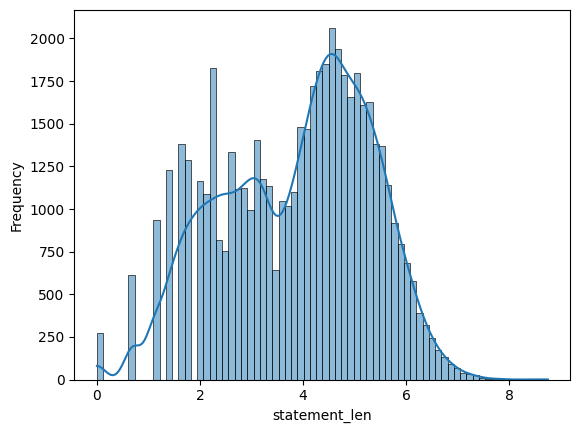

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


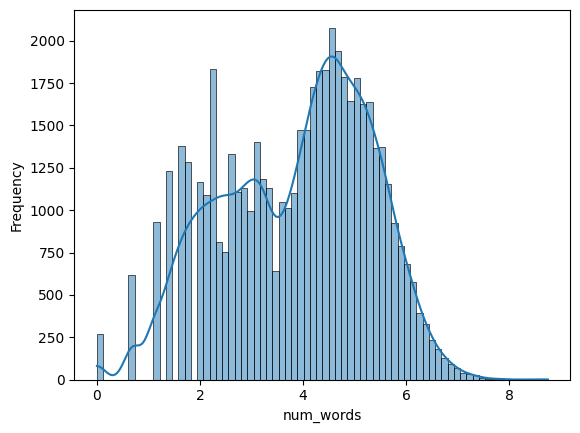

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


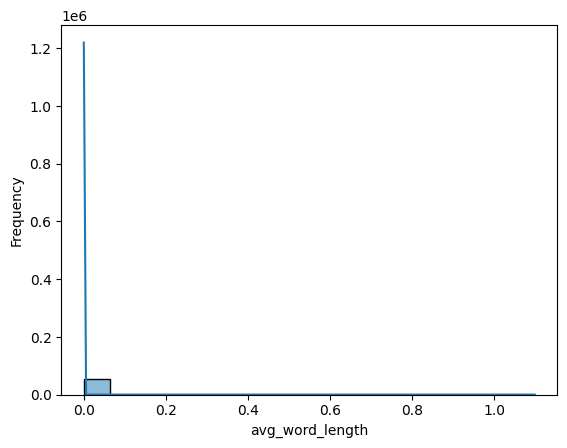

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


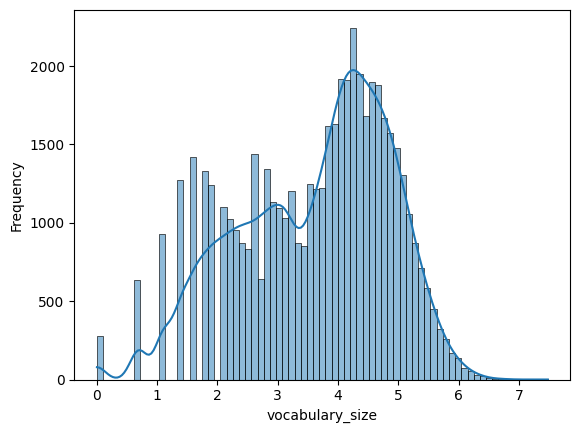

In [12]:
for feature in num_feature:
    data = df.copy()
    data[feature] = np.log(data[feature])
    sns.histplot(data = data, x=feature,kde=True)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

now lookin at the distribution, it almost have normal distribution of all of them

In [13]:
for feature in num_feature:
    df[feature] = np.log(df[feature])

df.head()

,statement,status,statement_len,num_words,avg_word_length,vocabulary_size
0,oh my gosh,Anxiety,1.098612,1.098612,0.0,1.098612
1,"trouble sleeping, confused mind, restless hear...",Anxiety,2.302585,2.302585,0.0,2.302585
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,2.639057,2.639057,0.0,2.564949
3,I've shifted my focus to something else but I'...,Anxiety,2.397895,2.397895,0.0,2.397895
4,"I'm restless and restless, it's been a month n...",Anxiety,2.639057,2.639057,0.0,2.639057


In [14]:
# Function to remove non-ASCII characters
def remove_non_ascii(text):
    return re.sub(r'[^\x00-\x7F]+', '', text)

# Normalize the text to remove special Unicode representations (e.g., accents)
def normalize_unicode(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('ascii')

# Function to clean text
def clean_text(text):
    # Normalize Unicode and remove non-ASCII
    text = remove_non_ascii(text)
    text = normalize_unicode(text)
    
    # Remove numbers and extra spaces
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize spaces
    
    # Remove random sequences and repeated characters
    text = re.sub(r'(.)\1{2,}', r'\1', text)  # Reduce repeated chars
    text = re.sub(r'\b\w*[^\w\s]\w*\b', '', text)  # Remove malformed words
    
    return text.lower()


the code above is to clean the text from Non-ASCII characters, and normalize unicode characters, and clean numbers and extra space, and remove random sequences and repeated character and lowering the text. 

In [15]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

setting the stopwords to englishm, then funciton to remove it.

the reason is to remove the noise in the data because stopwords are common words that not contribute much to the meaning of the sentence. 

In [16]:
# Apply the function to your 'statement' column
df['cleaned_statement'] = df['statement'].apply(clean_text)

In [17]:
df['cleaned_statement'] = df['statement'].apply(lambda x: remove_stopwords(x))

applying the clean text and remove stopwords function 

In [18]:
# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Stemming function
def stem_text(text):
    tokens = word_tokenize(text)
    stemmed = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed)

# Lemmatization function
def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized)

In [19]:
# Apply stemming and lemmatization
df['text_stemmed'] = df['statement'].apply(stem_text)
df['text_lemmatized'] = df['statement'].apply(lemmatize_text)

applying stemming and lemmatization, to the data before text representation 

# 4. Text Representation

In [20]:
df.sample(10)

,statement,status,statement_len,num_words,avg_word_length,vocabulary_size,cleaned_statement,text_stemmed,text_lemmatized
22549,My ex told me to get in a straight jacket. He ...,Suicidal,3.850148,3.850148,0.0,3.496508,My ex told get straight jacket . He told despi...,My ex told me to get in a straight jacket . He...,My ex told me to get in a straight jacket . He...
5668,the set of scented cake bats I say,Normal,2.079442,2.079442,0.0,2.079442,set scented cake bats I say,the set of scent cake bat I say,the set of scented cake bat I say
3654,"Crazy, it's been almost a year since CB left a...",Normal,2.397895,2.397895,0.0,2.397895,"Crazy , 's almost year since CB left right","crazi , it 's been almost a year sinc CB left ...","Crazy , it 's been almost a year since CB left..."
10602,Does anybody else feel better after imagining ...,Suicidal,3.912023,3.912023,0.0,3.828641,Does anybody else feel better imagining resort...,doe anybodi els feel better after imagin thems...,Does anybody else feel better after imagining ...
17343,"Every time I try to kill myself I plan it out,...",Suicidal,4.356709,4.356709,0.0,4.025352,"Every time I try kill I plan , get weapons rea...",everi time I tri to kill myself I plan it out ...,Every time I try to kill myself I plan it out ...
25779,"Hey, Brian, do us a favor and kill us before 1...",Depression,3.496508,3.496508,0.0,3.401197,"Hey , Brian , us favor kill us 16 . Thanks . F...","hey , brian , do us a favor and kill us befor ...","Hey , Brian , do u a favor and kill u before 1..."
29833,"Hello. As you can tell by the title, I'm conce...",Stress,4.510860,4.510860,0.0,4.248495,"Hello . As tell title , I 'm concerned little ...","hello . As you can tell by the titl , I 'm con...","Hello . As you can tell by the title , I 'm co..."
38900,so i have been on fluoxetine prozac for 0mg an...,Depression,3.555348,3.555348,0.0,3.332205,fluoxetine prozac 0mg seems make anxiety worse...,so i have been on fluoxetin prozac for 0mg and...,so i have been on fluoxetine prozac for 0mg an...
23728,Pls i need help. I cannot take it no more Coun...,Depression,2.397895,2.397895,0.0,2.397895,Pls need help . I take Counseling,pl i need help . I can not take it no more cou...,Pls i need help . I can not take it no more Co...
16787,Its currently 2:30am as I am writing this. I h...,Suicidal,4.521789,4.521789,0.0,4.219508,Its currently 2:30am I writing . I thinking bo...,it current 2:30am as I am write thi . I have b...,Its currently 2:30am a I am writing this . I h...


In [23]:
# Menggunakan kolom 'status' sebagai target
y = df['status']

# Encode target menggunakan LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Mapping label asli ke nilai encode
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapping Label:", label_mapping)

Mapping Label: {'Anxiety': 0, 'Bipolar': 1, 'Depression': 2, 'Normal': 3, 'Personality disorder': 4, 'Stress': 5, 'Suicidal': 6}


preparing the dataset, encode the label and shows its mapping. 

In [24]:
X_stemmed = df['text_stemmed']
X_lemmatized = df['text_lemmatized']

In [25]:
# TF-IDF Vectorization
tfidf_lemmatized = TfidfVectorizer()

X_tfidf_lemmatized = tfidf_lemmatized.fit_transform(X_lemmatized)

In [26]:
X_train_lemmatized, X_test_lemmatized = train_test_split(X_lemmatized, test_size=0.2, random_state=42)

In [31]:
X_train_lem, X_test_lem, y_train, y_test = train_test_split(X_tfidf_lemmatized, y_encoded, test_size=0.2, random_state=42)

data spliting for lemmatized tfidf data

# 5. Modelling, Experimenting & Evaluation 

In [28]:
mlp_model = MLPClassifier(random_state=42, max_iter=300)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

creating the models of MLP and XGB

#### Below are all the experiments and the evaluation that works 

In [32]:
# Train and evaluate MLP on lemmatized data
mlp_model.fit(X_train_lem, y_train)
y_pred_mlp_lem = mlp_model.predict(X_test_lem)
print("MLP on Lemmatized Data:\n", classification_report(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred_mlp_lem)))

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLP on Lemmatized Data:
                       precision    recall  f1-score   support

             Anxiety       0.77      0.73      0.75       755
             Bipolar       0.85      0.73      0.78       527
          Depression       0.64      0.67      0.65      3016
              Normal       0.88      0.93      0.90      3308
Personality disorder       0.83      0.59      0.69       237
              Stress       0.63      0.53      0.58       536
            Suicidal       0.63      0.60      0.62      2158

            accuracy                           0.74     10537
           macro avg       0.75      0.68      0.71     10537
        weighted avg       0.74      0.74      0.73     10537



In [34]:
# Train and evaluate XGBoost on lemmatized data
xgb_model.fit(X_train_lem, y_train)
y_pred_xgb_lem = xgb_model.predict(X_test_lem)
print("XGBoost on Lemmatized Data:\n", classification_report(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred_xgb_lem)))

XGBoost on Lemmatized Data:
                       precision    recall  f1-score   support

             Anxiety       0.80      0.74      0.77       755
             Bipolar       0.87      0.76      0.81       527
          Depression       0.68      0.72      0.70      3016
              Normal       0.88      0.94      0.91      3308
Personality disorder       0.95      0.60      0.73       237
              Stress       0.68      0.53      0.60       536
            Suicidal       0.70      0.67      0.68      2158

            accuracy                           0.77     10537
           macro avg       0.80      0.71      0.74     10537
        weighted avg       0.77      0.77      0.77     10537



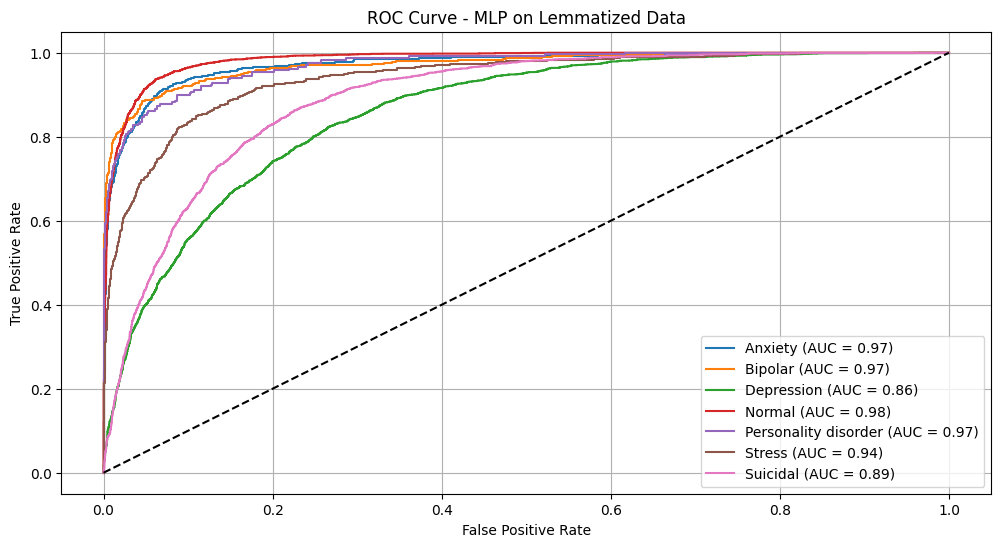

In [37]:
# Get the predicted probabilities for each class
y_pred_prob_mlp = mlp_model.predict_proba(X_test_lem)
y_pred_prob_xgb = xgb_model.predict_proba(X_test_lem)

# Define classes
classes = label_encoder.inverse_transform(np.unique(y_test))

# Plot ROC AUC curve for MLP
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test == i, y_pred_prob_mlp[:, i])  # True labels vs predicted probabilities
    auc = roc_auc_score(y_test == i, y_pred_prob_mlp[:, i])  # AUC score
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MLP on Lemmatized Data')
plt.legend(loc='lower right')
plt.grid()
plt.show()

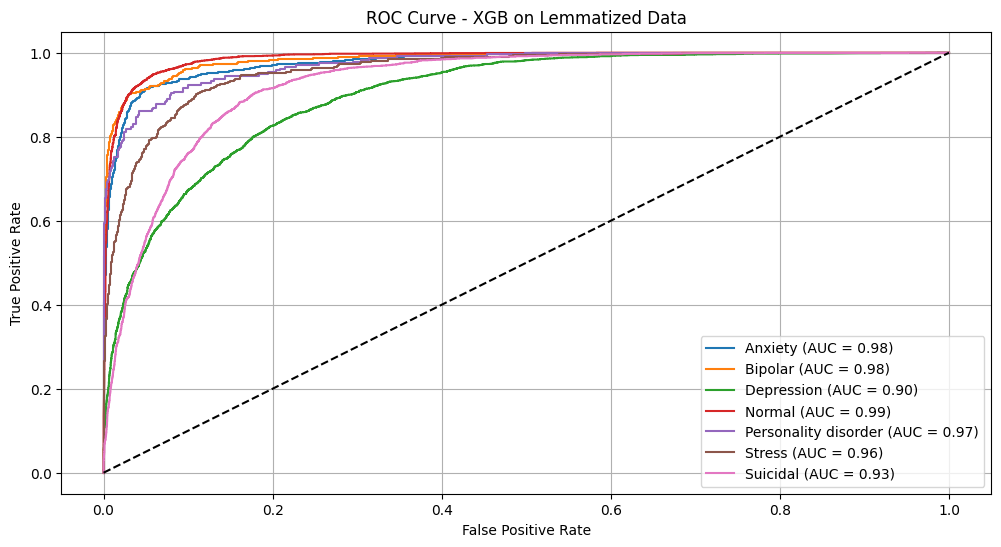

In [38]:
# Plot ROC AUC curve for XGB
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test == i, y_pred_prob_xgb[:, i])  # True labels vs predicted probabilities
    auc = roc_auc_score(y_test == i, y_pred_prob_xgb[:, i])  # AUC score
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGB on Lemmatized Data')
plt.legend(loc='lower right')
plt.grid()
plt.show()

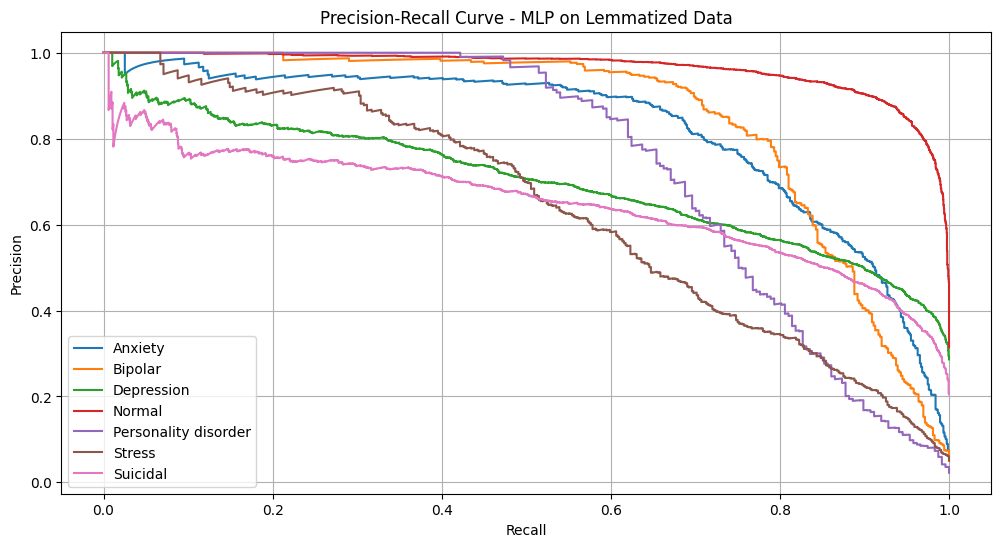

In [39]:
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test == i, y_pred_prob_mlp[:, i])
    plt.plot(recall, precision, label=f'{class_name}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - MLP on Lemmatized Data')
plt.legend(loc='best')
plt.grid()
plt.show()

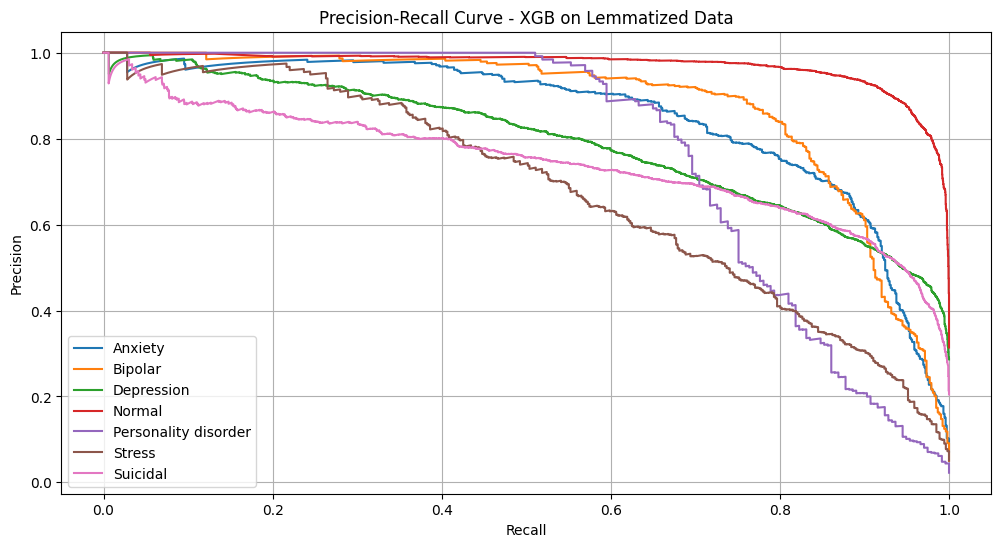

In [40]:
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test == i, y_pred_prob_xgb[:, i])
    plt.plot(recall, precision, label=f'{class_name}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGB on Lemmatized Data')
plt.legend(loc='best')
plt.grid()
plt.show()

the models show significant result it could be said that the model are not that bad because on average it could predict 0.77 for XGB and 0.74 for MLP.

but some further experiments on handling imbalance can be done.

In [42]:
# Check original class distribution
print("Original class distribution:")
Counter(label_encoder.inverse_transform(y_encoded))

Original class distribution:


Counter({'Normal': 16343,
         'Depression': 15404,
         'Suicidal': 10652,
         'Anxiety': 3841,
         'Bipolar': 2777,
         'Stress': 2587,
         'Personality disorder': 1077})

looking at the class distribution the number of classes are very imbalance, so to deal with it we need to do oversampling or undersampling and test it to the models again.

In [44]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_tfidf_lemmatized, y_encoded)

# Check class distribution after SMOTE
print("Class distribution after SMOTE:")
Counter(label_encoder.inverse_transform(y_resampled_smote))

Class distribution after SMOTE:


Counter({'Anxiety': 16343,
         'Normal': 16343,
         'Depression': 16343,
         'Suicidal': 16343,
         'Stress': 16343,
         'Bipolar': 16343,
         'Personality disorder': 16343})

In [45]:
# Apply Undersampling
undersampler = RandomUnderSampler(random_state=42)
X_resampled_undersample, y_resampled_undersample = undersampler.fit_resample(X_tfidf_lemmatized, y_encoded)

# Check class distribution after undersampling
print("Class distribution after undersampling:")
Counter(label_encoder.inverse_transform(y_resampled_undersample))

Class distribution after undersampling:


Counter({'Anxiety': 1077,
         'Bipolar': 1077,
         'Depression': 1077,
         'Normal': 1077,
         'Personality disorder': 1077,
         'Stress': 1077,
         'Suicidal': 1077})

oversample and undersampling are used now, time to split the data and fit to the model and evaluate

In [46]:
X_train_oversample, X_test_oversample, y_train_oversample, y_test_oversample = train_test_split(X_resampled_smote, y_resampled_smote, test_size=0.2, random_state=42)

In [47]:
# Initialize and train MLP
mlp_model_oversample = MLPClassifier(random_state=42)
mlp_model_oversample.fit(X_train_oversample, y_train_oversample)

# Make predictions
y_pred_mlp_oversample = mlp_model_oversample.predict(X_test_oversample)

# Evaluate the model
print("MLP Model Performance:\n", classification_report(label_encoder.inverse_transform(y_test_oversample), label_encoder.inverse_transform(y_pred_mlp_oversample)))

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLP Model Performance:
                       precision    recall  f1-score   support

             Anxiety       0.96      0.97      0.97      3375
             Bipolar       0.98      0.98      0.98      3214
          Depression       0.77      0.65      0.71      3274
              Normal       0.91      0.94      0.93      3325
Personality disorder       0.98      1.00      0.99      3241
              Stress       0.93      0.97      0.95      3209
            Suicidal       0.77      0.82      0.79      3243

            accuracy                           0.90     22881
           macro avg       0.90      0.90      0.90     22881
        weighted avg       0.90      0.90      0.90     22881



In [48]:
xgb_model_oversample = XGBClassifier(random_state=42)
xgb_model_oversample.fit(X_train_oversample, y_train_oversample)

# Make predictions
y_pred_xgb_oversample = xgb_model_oversample.predict(X_test_oversample)

# Evaluate the model
print("XGBoost Model Performance:\n", classification_report(label_encoder.inverse_transform(y_test_oversample), label_encoder.inverse_transform(y_pred_xgb_oversample)))

XGBoost Model Performance:
                       precision    recall  f1-score   support

             Anxiety       0.95      0.95      0.95      3375
             Bipolar       0.98      0.96      0.97      3214
          Depression       0.73      0.68      0.71      3274
              Normal       0.87      0.94      0.91      3325
Personality disorder       0.99      0.97      0.98      3241
              Stress       0.94      0.93      0.93      3209
            Suicidal       0.77      0.79      0.78      3243

            accuracy                           0.89     22881
           macro avg       0.89      0.89      0.89     22881
        weighted avg       0.89      0.89      0.89     22881



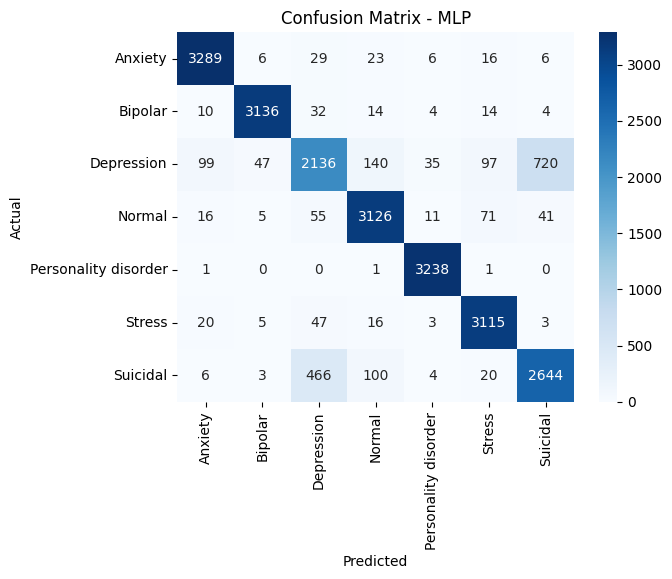

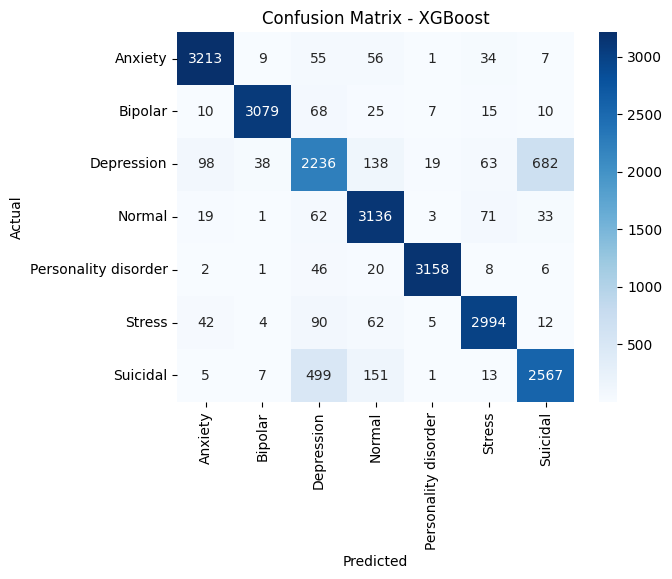

In [49]:
# Confusion matrix for MLP
cm_mlp = confusion_matrix(y_test_oversample, y_pred_mlp_oversample)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - MLP")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Confusion matrix for XGBoost
cm_xgb = confusion_matrix(y_test_oversample, y_pred_xgb_oversample)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

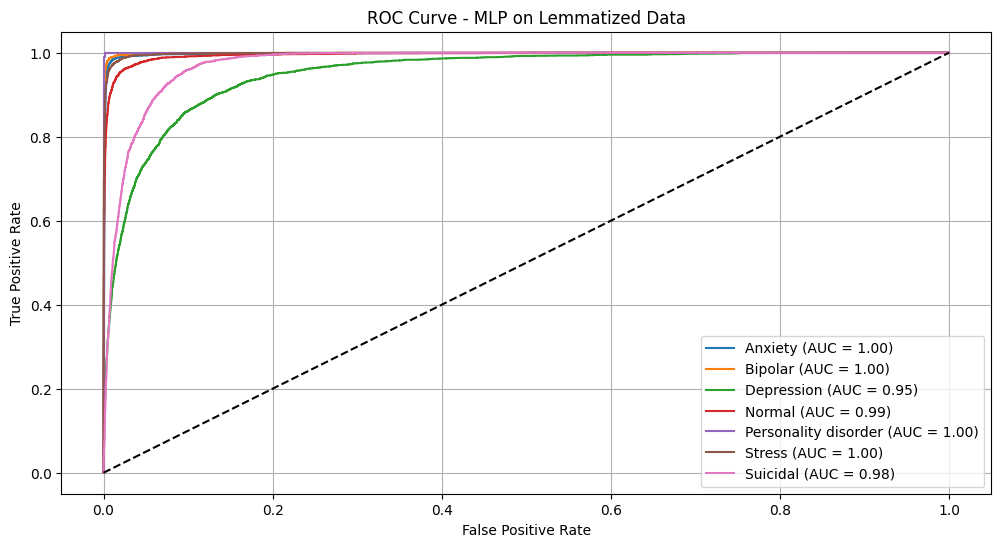

In [50]:
# Get the predicted probabilities for each class
y_pred_prob_mlp_oversample = mlp_model_oversample.predict_proba(X_test_oversample)
y_pred_prob_xgb_oversample = xgb_model_oversample.predict_proba(X_test_oversample)

# Define classes
classes = label_encoder.inverse_transform(np.unique(y_test))

# Plot ROC AUC curve for MLP
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_oversample == i, y_pred_prob_mlp_oversample[:, i])  # True labels vs predicted probabilities
    auc = roc_auc_score(y_test_oversample == i, y_pred_prob_mlp_oversample[:, i])  # AUC score
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MLP on Lemmatized Data')
plt.legend(loc='lower right')
plt.grid()
plt.show()

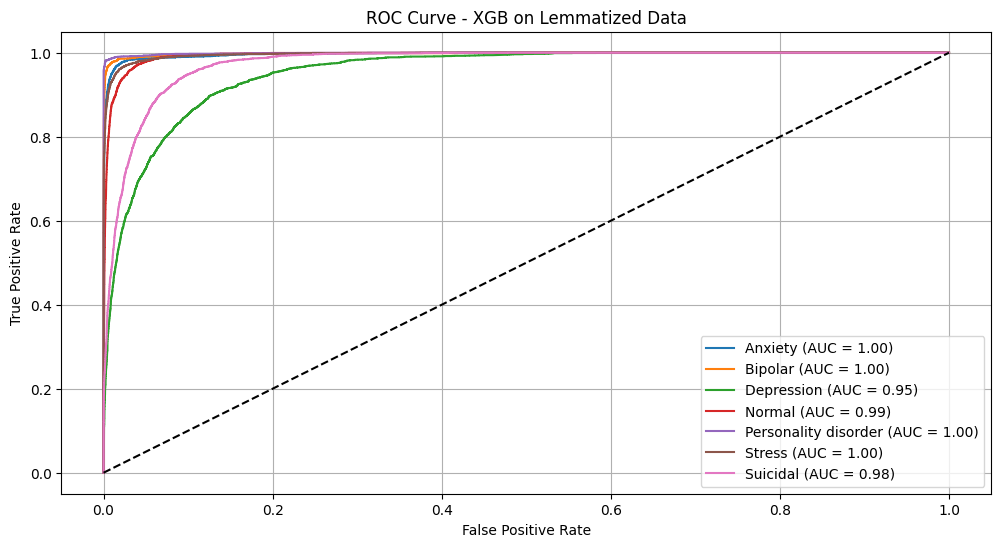

In [51]:
# Plot ROC AUC curve for MLP
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_oversample == i, y_pred_prob_xgb_oversample[:, i])  # True labels vs predicted probabilities
    auc = roc_auc_score(y_test_oversample == i, y_pred_prob_xgb_oversample[:, i])  # AUC score
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGB on Lemmatized Data')
plt.legend(loc='lower right')
plt.grid()
plt.show()

from the evaluation above, we can see that MLP works better on oversampled data with 0.9 overall accuracy and have almost perfect ROC, while XGB can also on par with MLP with 0.89.

In [52]:
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_resampled_undersample, y_resampled_undersample, test_size=0.2, random_state=42)

In [53]:
# Initialize and train MLP
mlp_model_undersample = MLPClassifier(random_state=42)
mlp_model_undersample.fit(X_train_undersample, y_train_undersample)

# Make predictions
y_pred_mlp_undersample = mlp_model_undersample.predict(X_test_undersample)

print("MLP Model Performance:\n", classification_report(label_encoder.inverse_transform(y_test_undersample), label_encoder.inverse_transform(y_pred_mlp_undersample)))

MLP Model Performance:
                       precision    recall  f1-score   support

             Anxiety       0.79      0.75      0.77       226
             Bipolar       0.84      0.82      0.83       233
          Depression       0.45      0.45      0.45       220
              Normal       0.77      0.89      0.83       197
Personality disorder       0.74      0.78      0.76       215
              Stress       0.64      0.58      0.61       204
            Suicidal       0.65      0.65      0.65       213

            accuracy                           0.70      1508
           macro avg       0.70      0.70      0.70      1508
        weighted avg       0.70      0.70      0.70      1508



/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [54]:
xgb_model_undersample = XGBClassifier(random_state=42)
xgb_model_undersample.fit(X_train_undersample, y_train_undersample)

# Make predictions
y_pred_xgb_undersample = xgb_model_undersample.predict(X_test_undersample)

# Evaluate the model
print("XGBoost Model Performance:\n", classification_report(label_encoder.inverse_transform(y_test_undersample), label_encoder.inverse_transform(y_pred_xgb_undersample)))

XGBoost Model Performance:
                       precision    recall  f1-score   support

             Anxiety       0.76      0.75      0.76       226
             Bipolar       0.86      0.81      0.83       233
          Depression       0.54      0.49      0.52       220
              Normal       0.80      0.88      0.84       197
Personality disorder       0.77      0.77      0.77       215
              Stress       0.63      0.66      0.65       204
            Suicidal       0.65      0.67      0.66       213

            accuracy                           0.72      1508
           macro avg       0.72      0.72      0.72      1508
        weighted avg       0.72      0.72      0.72      1508



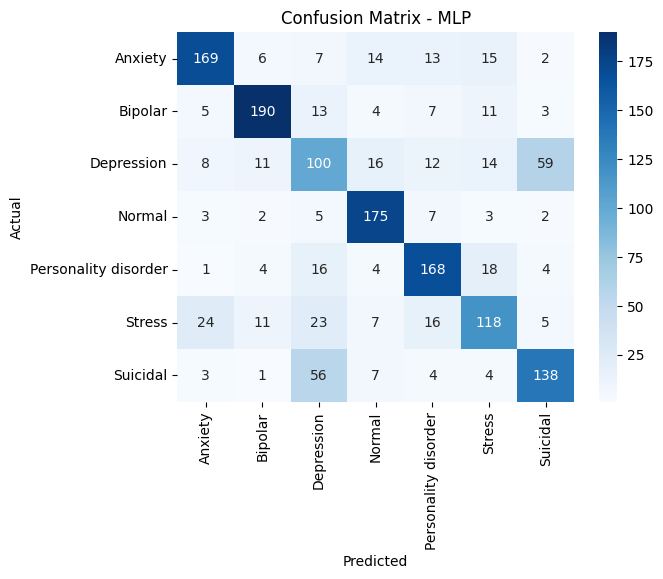

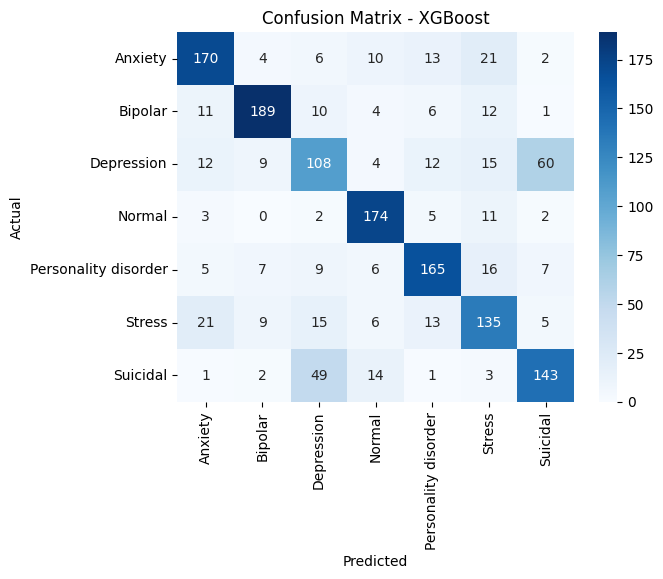

In [55]:
# Confusion matrix for MLP
cm_mlp = confusion_matrix(y_test_undersample, y_pred_mlp_undersample)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - MLP")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Confusion matrix for XGBoost
cm_xgb = confusion_matrix(y_test_undersample, y_pred_xgb_undersample)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

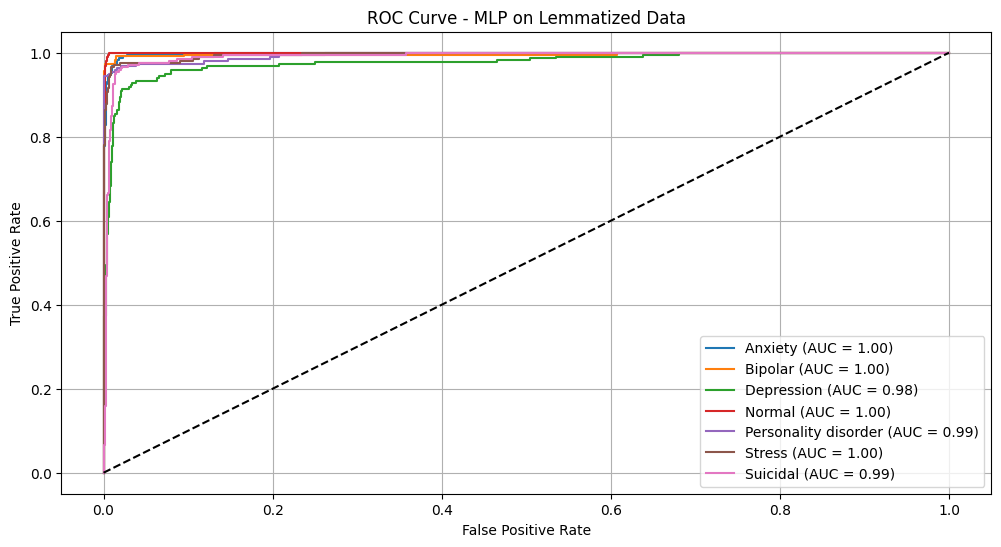

In [56]:
# Get the predicted probabilities for each class
y_pred_prob_mlp_undersample = mlp_model.predict_proba(X_test_undersample)
y_pred_prob_xgb_undersample = xgb_model.predict_proba(X_test_undersample)

# Define classes
classes = label_encoder.inverse_transform(np.unique(y_test_undersample))

# Plot ROC AUC curve for MLP
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_undersample == i, y_pred_prob_mlp_undersample[:, i])  # True labels vs predicted probabilities
    auc = roc_auc_score(y_test_undersample == i, y_pred_prob_mlp_undersample[:, i])  # AUC score
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MLP on Lemmatized Data')
plt.legend(loc='lower right')
plt.grid()
plt.show()

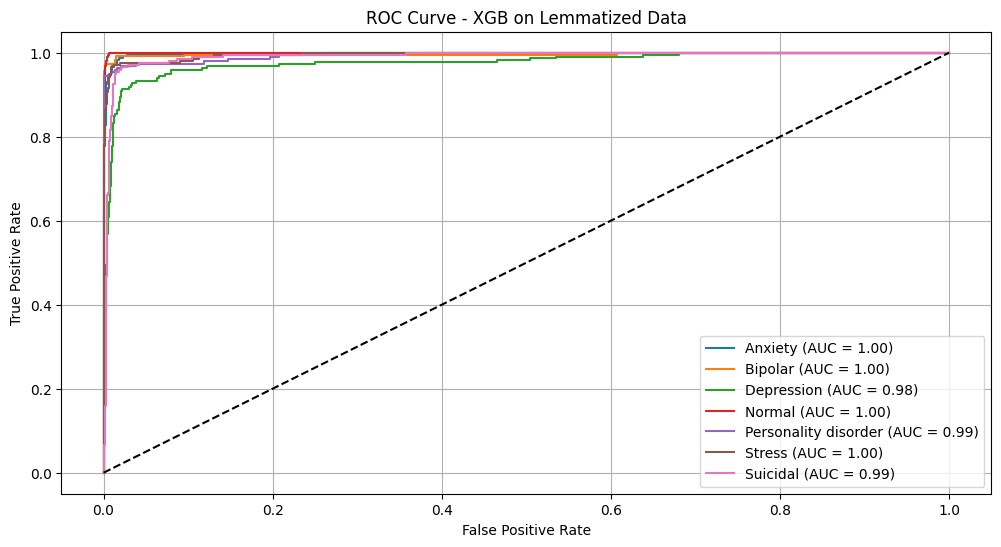

In [57]:
# Plot ROC AUC curve for MLP
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_undersample == i, y_pred_prob_mlp_undersample[:, i])  # True labels vs predicted probabilities
    auc = roc_auc_score(y_test_undersample == i, y_pred_prob_mlp_undersample[:, i])  # AUC score
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGB on Lemmatized Data')
plt.legend(loc='lower right')
plt.grid()
plt.show()

looking at the undersampled data the result are not that satisfied with both models accuracy, MLP with 0.70 and XGB with 0.72 this can be happen because of the much data are being cut and less information are being capture

## STEMED DATA

now doing the same things for the stemmed data, lets check on the model performance

In [58]:
# TF-IDF Vectorization
tfidf_stemmed = TfidfVectorizer()
X_tfidf_stemmed = tfidf_stemmed.fit_transform(X_stemmed)

In [59]:
# Split data
X_train_stem, X_test_stem, y_train, y_test = train_test_split(X_tfidf_stemmed, y_encoded, test_size=0.2, random_state=42)

In [60]:
# Initialize models
mlp_model = MLPClassifier(random_state=42, max_iter=300)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

In [61]:
# Train and evaluate MLP on stemmed data
mlp_model.fit(X_train_stem, y_train)
y_pred_mlp_stem = mlp_model.predict(X_test_stem)
print("MLP on Stemmed Data:\n", classification_report(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred_mlp_stem)))

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLP on Stemmed Data:
                       precision    recall  f1-score   support

             Anxiety       0.77      0.76      0.76       755
             Bipolar       0.85      0.75      0.80       527
          Depression       0.64      0.65      0.65      3016
              Normal       0.89      0.92      0.91      3308
Personality disorder       0.82      0.56      0.67       237
              Stress       0.64      0.58      0.60       536
            Suicidal       0.62      0.64      0.63      2158

            accuracy                           0.74     10537
           macro avg       0.75      0.69      0.72     10537
        weighted avg       0.74      0.74      0.74     10537



In [62]:
# Train and evaluate XGBoost on stemmed data
xgb_model.fit(X_train_stem, y_train)
y_pred_xgb_stem = xgb_model.predict(X_test_stem)
print("XGBoost on Stemmed Data:\n", classification_report(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred_xgb_stem)))

XGBoost on Stemmed Data:
                       precision    recall  f1-score   support

             Anxiety       0.81      0.77      0.79       755
             Bipolar       0.87      0.78      0.82       527
          Depression       0.69      0.73      0.71      3016
              Normal       0.89      0.95      0.92      3308
Personality disorder       0.91      0.59      0.71       237
              Stress       0.71      0.55      0.62       536
            Suicidal       0.70      0.67      0.68      2158

            accuracy                           0.78     10537
           macro avg       0.80      0.72      0.75     10537
        weighted avg       0.78      0.78      0.78     10537



without undersampling and oversampling the model works quite well almost similiar to the lemmatized data

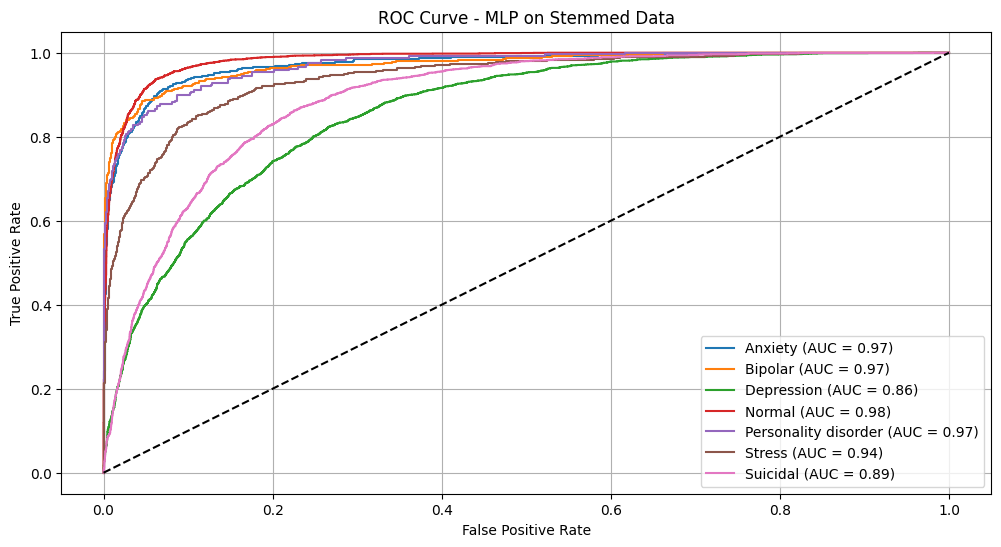

In [63]:
# Plot ROC AUC curve for MLP
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test == i, y_pred_prob_mlp[:, i])  # True labels vs predicted probabilities
    auc = roc_auc_score(y_test == i, y_pred_prob_mlp[:, i])  # AUC score
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MLP on Stemmed Data')
plt.legend(loc='lower right')
plt.grid()
plt.show()

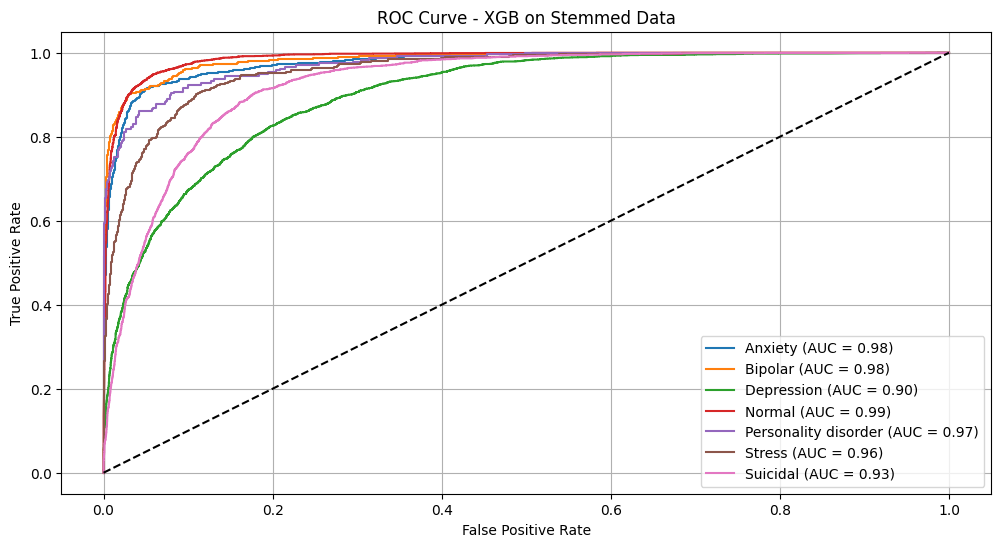

In [64]:
# Plot ROC AUC curve for XGB
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test == i, y_pred_prob_xgb[:, i])  # True labels vs predicted probabilities
    auc = roc_auc_score(y_test == i, y_pred_prob_xgb[:, i])  # AUC score
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGB on Stemmed Data')
plt.legend(loc='lower right')
plt.grid()
plt.show()

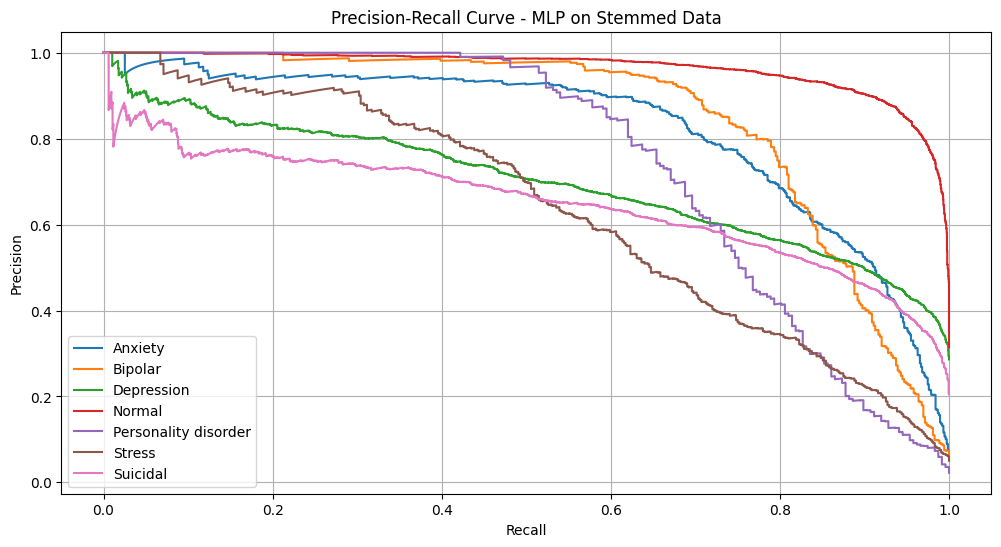

In [65]:
# Precision-Recall Curve for MLP
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test == i, y_pred_prob_mlp[:, i])
    plt.plot(recall, precision, label=f'{class_name}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - MLP on Stemmed Data')
plt.legend(loc='best')
plt.grid()
plt.show()

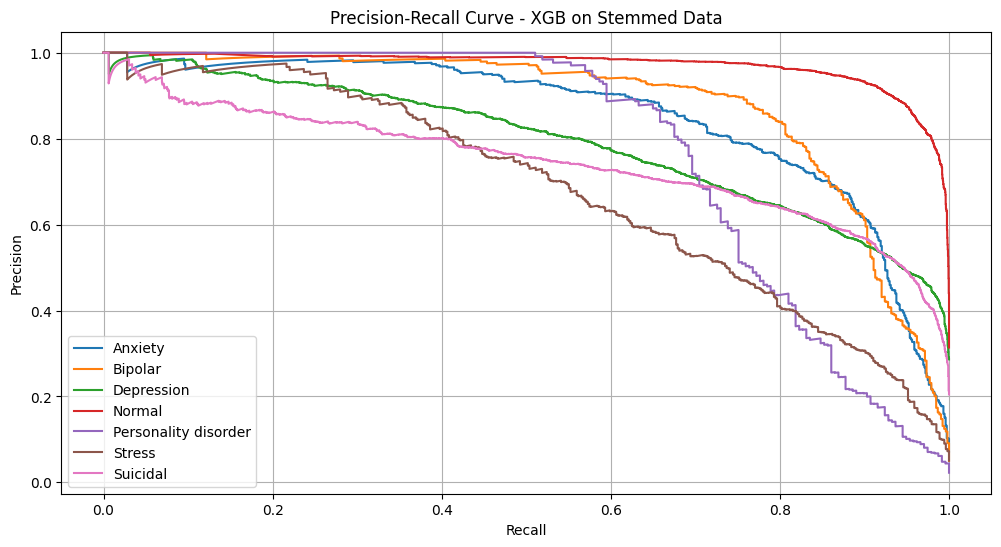

In [66]:
# Precision-Recall Curve for XGB
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test == i, y_pred_prob_xgb[:, i])
    plt.plot(recall, precision, label=f'{class_name}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGB on Stemmed Data')
plt.legend(loc='best')
plt.grid()
plt.show()

In [67]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_tfidf_stemmed, y_encoded)

# Check class distribution after SMOTE
print("Class distribution after SMOTE:")
Counter(label_encoder.inverse_transform(y_resampled_smote))


Class distribution after SMOTE:


Counter({'Anxiety': 16343,
         'Normal': 16343,
         'Depression': 16343,
         'Suicidal': 16343,
         'Stress': 16343,
         'Bipolar': 16343,
         'Personality disorder': 16343})

In [68]:
# Apply Undersampling
undersampler = RandomUnderSampler(random_state=42)
X_resampled_undersample, y_resampled_undersample = undersampler.fit_resample(X_tfidf_stemmed, y_encoded)

# Check class distribution after undersampling
print("Class distribution after undersampling:")
Counter(label_encoder.inverse_transform(y_resampled_undersample))


Class distribution after undersampling:


Counter({'Anxiety': 1077,
         'Bipolar': 1077,
         'Depression': 1077,
         'Normal': 1077,
         'Personality disorder': 1077,
         'Stress': 1077,
         'Suicidal': 1077})

In [69]:
X_train_oversample, X_test_oversample, y_train_oversample, y_test_oversample = train_test_split(X_resampled_smote, y_resampled_smote, test_size=0.2, random_state=42)

In [70]:
# Initialize and train MLP
mlp_model_oversample = MLPClassifier(random_state=42)
mlp_model_oversample.fit(X_train_oversample, y_train_oversample)

# Make predictions
y_pred_mlp_oversample = mlp_model_oversample.predict(X_test_oversample)

# Evaluate the model
print("MLP Model Performance:\n", classification_report(label_encoder.inverse_transform(y_test_oversample), label_encoder.inverse_transform(y_pred_mlp_oversample)))


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLP Model Performance:
                       precision    recall  f1-score   support

             Anxiety       0.96      0.98      0.97      3375
             Bipolar       0.98      0.98      0.98      3214
          Depression       0.78      0.64      0.70      3274
              Normal       0.92      0.93      0.92      3325
Personality disorder       0.98      1.00      0.99      3241
              Stress       0.95      0.98      0.96      3209
            Suicidal       0.76      0.82      0.79      3243

            accuracy                           0.91     22881
           macro avg       0.90      0.91      0.90     22881
        weighted avg       0.90      0.91      0.90     22881



In [71]:
xgb_model_oversample = XGBClassifier(random_state=42)
xgb_model_oversample.fit(X_train_oversample, y_train_oversample)

# Make predictions
y_pred_xgb_oversample = xgb_model_oversample.predict(X_test_oversample)

# Evaluate the model
print("XGBoost Model Performance:\n", classification_report(label_encoder.inverse_transform(y_test_oversample), label_encoder.inverse_transform(y_pred_xgb_oversample)))


XGBoost Model Performance:
                       precision    recall  f1-score   support

             Anxiety       0.95      0.95      0.95      3375
             Bipolar       0.98      0.96      0.97      3214
          Depression       0.73      0.68      0.71      3274
              Normal       0.88      0.94      0.91      3325
Personality disorder       0.99      0.98      0.98      3241
              Stress       0.93      0.93      0.93      3209
            Suicidal       0.77      0.78      0.78      3243

            accuracy                           0.89     22881
           macro avg       0.89      0.89      0.89     22881
        weighted avg       0.89      0.89      0.89     22881



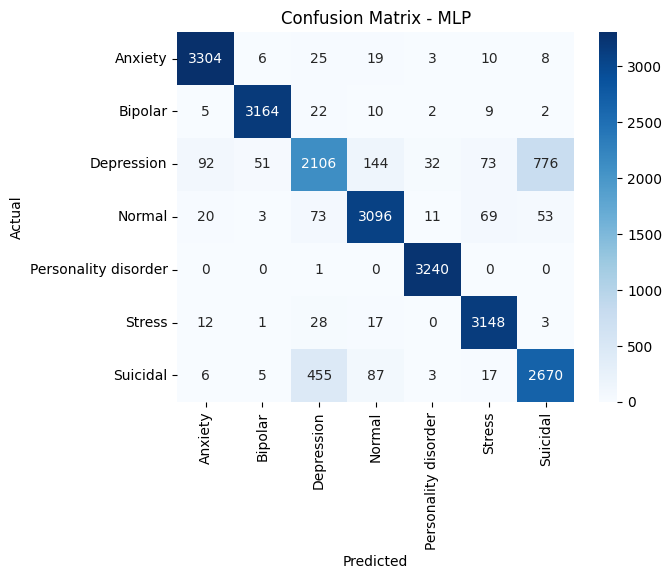

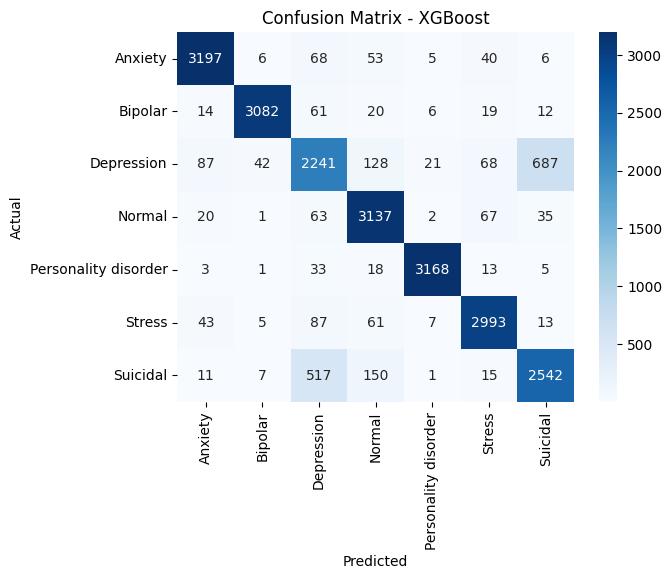

In [72]:
# Confusion matrix for MLP
cm_mlp = confusion_matrix(y_test_oversample, y_pred_mlp_oversample)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - MLP")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Confusion matrix for XGBoost
cm_xgb = confusion_matrix(y_test_oversample, y_pred_xgb_oversample)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

here another prove of MLP works best with oversampling, with 0.91  and XGB with the sampe accuracy as lemmatization oversample, 0.89

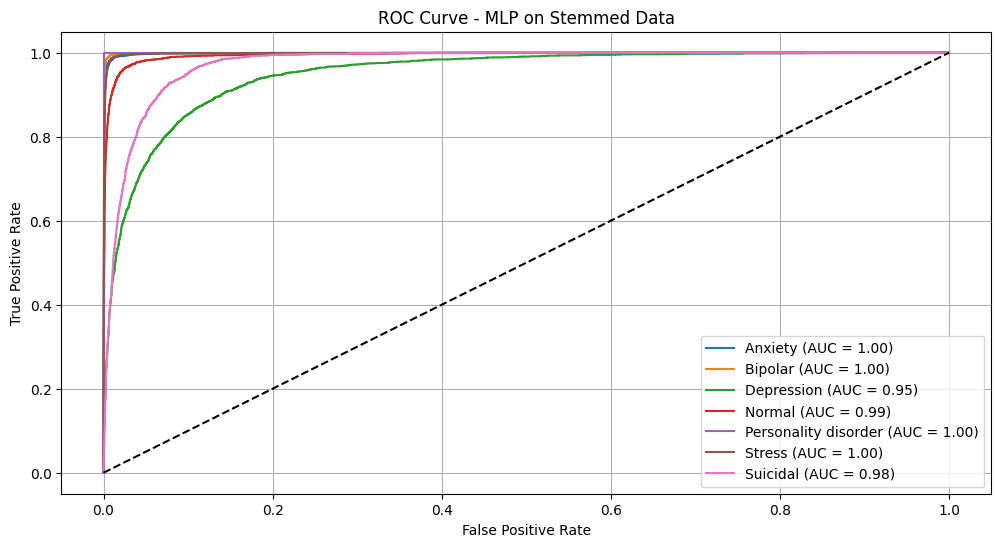

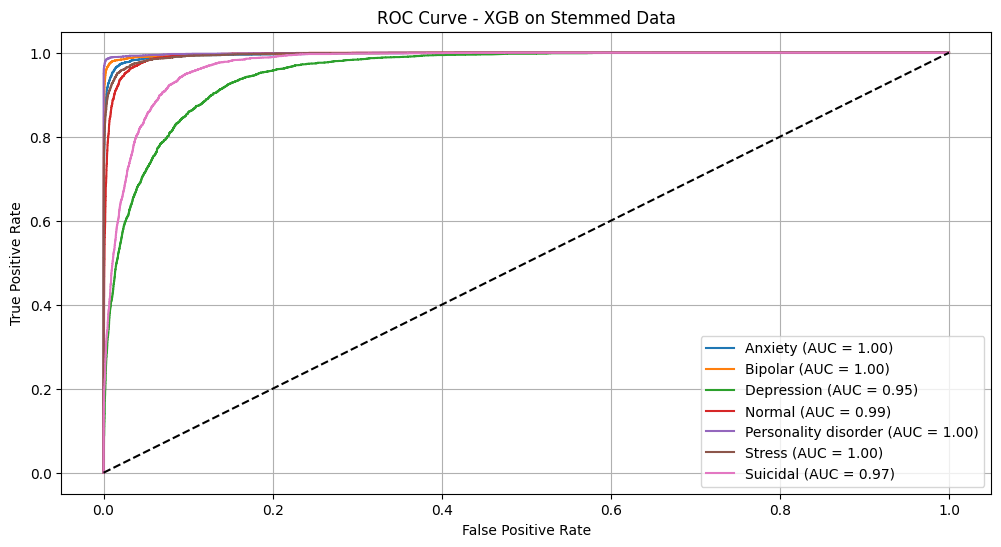

In [80]:
# Get the predicted probabilities for each class
y_pred_prob_mlp_oversample = mlp_model_oversample.predict_proba(X_test_oversample)
y_pred_prob_xgb_oversample = xgb_model_oversample.predict_proba(X_test_oversample)

# Define classes
classes = label_encoder.inverse_transform(np.unique(y_test))

# Plot ROC AUC curve for MLP
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_oversample == i, y_pred_prob_mlp_oversample[:, i])  # True labels vs predicted probabilities
    auc = roc_auc_score(y_test_oversample == i, y_pred_prob_mlp_oversample[:, i])  # AUC score
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MLP on Stemmed Data')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Plot ROC AUC curve for MLP
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_oversample == i, y_pred_prob_xgb_oversample[:, i])  # True labels vs predicted probabilities
    auc = roc_auc_score(y_test_oversample == i, y_pred_prob_xgb_oversample[:, i])  # AUC score
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGB on Stemmed Data')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [74]:
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_resampled_undersample, y_resampled_undersample, test_size=0.2, random_state=42)

In [75]:
# Initialize and train MLP
mlp_model_undersample = MLPClassifier(random_state=42)
mlp_model_undersample.fit(X_train_undersample, y_train_undersample)

# Make predictions
y_pred_mlp_undersample = mlp_model_undersample.predict(X_test_undersample)

print("MLP Model Performance:\n", classification_report(label_encoder.inverse_transform(y_test_undersample), label_encoder.inverse_transform(y_pred_mlp_undersample)))


MLP Model Performance:
                       precision    recall  f1-score   support

             Anxiety       0.75      0.72      0.74       226
             Bipolar       0.85      0.83      0.84       233
          Depression       0.46      0.49      0.47       220
              Normal       0.79      0.86      0.82       197
Personality disorder       0.77      0.78      0.77       215
              Stress       0.62      0.56      0.59       204
            Suicidal       0.64      0.64      0.64       213

            accuracy                           0.70      1508
           macro avg       0.70      0.70      0.70      1508
        weighted avg       0.70      0.70      0.70      1508



/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [76]:
xgb_model_undersample = XGBClassifier(random_state=42)
xgb_model_undersample.fit(X_train_undersample, y_train_undersample)

# Make predictions
y_pred_xgb_undersample = xgb_model_undersample.predict(X_test_undersample)

# Evaluate the model
print("XGBoost Model Performance:\n", classification_report(label_encoder.inverse_transform(y_test_undersample), label_encoder.inverse_transform(y_pred_xgb_undersample)))


XGBoost Model Performance:
                       precision    recall  f1-score   support

             Anxiety       0.79      0.80      0.80       226
             Bipolar       0.89      0.84      0.86       233
          Depression       0.60      0.53      0.56       220
              Normal       0.86      0.87      0.86       197
Personality disorder       0.76      0.82      0.79       215
              Stress       0.65      0.67      0.66       204
            Suicidal       0.68      0.71      0.69       213

            accuracy                           0.75      1508
           macro avg       0.75      0.75      0.75      1508
        weighted avg       0.75      0.75      0.75      1508



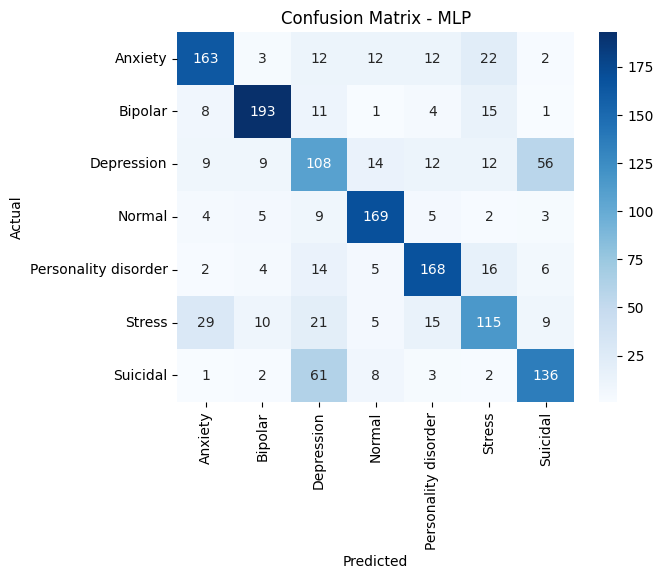

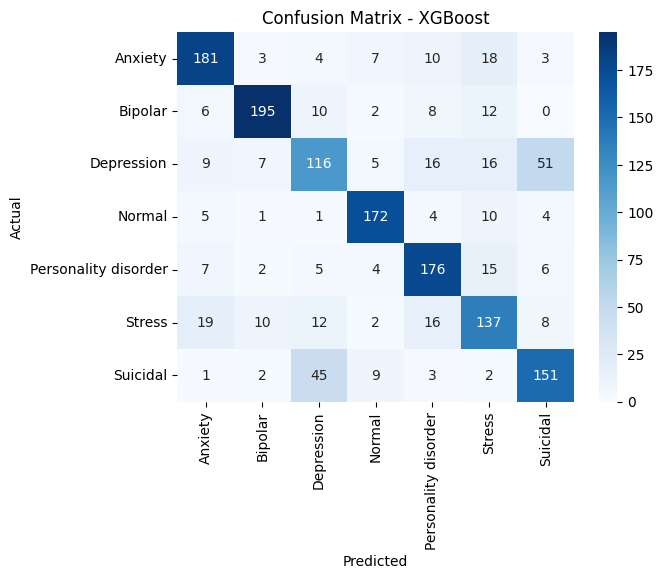

In [77]:
# Confusion matrix for MLP
cm_mlp = confusion_matrix(y_test_undersample, y_pred_mlp_undersample)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - MLP")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Confusion matrix for XGBoost
cm_xgb = confusion_matrix(y_test_undersample, y_pred_xgb_undersample)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


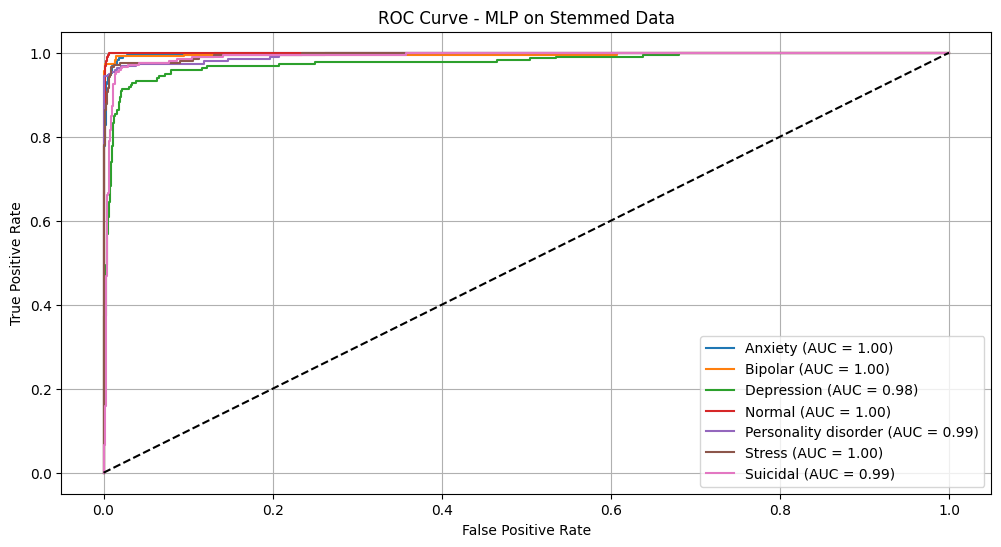

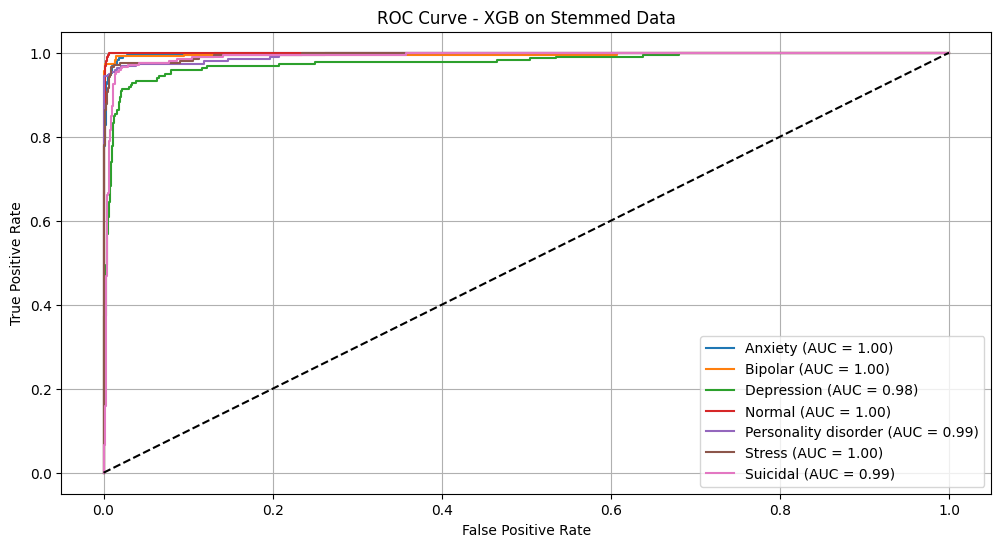

In [79]:
# Plot ROC AUC curve for MLP
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_undersample == i, y_pred_prob_mlp_undersample[:, i])  # True labels vs predicted probabilities
    auc = roc_auc_score(y_test_undersample == i, y_pred_prob_mlp_undersample[:, i])  # AUC score
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MLP on Stemmed Data')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Plot ROC AUC curve for MLP
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_undersample == i, y_pred_prob_mlp_undersample[:, i])  # True labels vs predicted probabilities
    auc = roc_auc_score(y_test_undersample == i, y_pred_prob_mlp_undersample[:, i])  # AUC score
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGB on Stemmed Data')
plt.legend(loc='lower right')
plt.grid()
plt.show()

undersample is not performing well with same issues that might happen

# 6. Documentation 

# Model Evaluation Summary

### Lemmatization + TFIDF
| Model         | Precision (Macro Avg) | Recall (Macro Avg) | F1-Score (Macro Avg) | Accuracy |
|---------------|------------------------|---------------------|-----------------------|----------|
| MLP           | 0.75                  | 0.68                | 0.71                 | 0.74     |
| XGBoost       | 0.80                  | 0.71                | 0.74                 | 0.77     |

### Lemmatization + TFIDF (Oversample)
| Model         | Precision (Macro Avg) | Recall (Macro Avg) | F1-Score (Macro Avg) | Accuracy |
|---------------|------------------------|---------------------|-----------------------|----------|
| MLP           | 0.90                  | 0.90                | 0.90                 | 0.90     |
| XGBoost       | 0.89                  | 0.89                | 0.89                 | 0.89     |

### Lemmatization + TFIDF (Undersample)
| Model         | Precision (Macro Avg) | Recall (Macro Avg) | F1-Score (Macro Avg) | Accuracy |
|---------------|------------------------|---------------------|-----------------------|----------|
| MLP           | 0.70                  | 0.70                | 0.70                 | 0.70     |
| XGBoost       | 0.72                  | 0.72                | 0.72                 | 0.72     |


### Stemmed TFIDF
| Model         | Precision (Macro Avg) | Recall (Macro Avg) | F1-Score (Macro Avg) | Accuracy |
|---------------|------------------------|---------------------|-----------------------|----------|
| MLP           | 0.75                  | 0.69                | 0.72                 | 0.74     |
| XGBoost       | 0.80                  | 0.72                | 0.75                 | 0.78     |

### Stemmed TFIDF (Oversample)
| Model         | Precision (Macro Avg) | Recall (Macro Avg) | F1-Score (Macro Avg) | Accuracy |
|---------------|------------------------|---------------------|-----------------------|----------|
| MLP           | 0.90                  | 0.91                | 0.90                 | 0.91     |
| XGBoost       | 0.89                  | 0.89                | 0.89                 | 0.89     |

### Stemmed TFIDF (Undersample)
| Model         | Precision (Macro Avg) | Recall (Macro Avg) | F1-Score (Macro Avg) | Accuracy |
|---------------|------------------------|---------------------|-----------------------|----------|
| MLP           | 0.70                  | 0.70                | 0.70                 | 0.70     |
| XGBoost       | 0.75                  | 0.75                | 0.75                 | 0.75     |
